In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

warnings.filterwarnings('ignore')

import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device: ', device)

Using device:  mps


# Load flow neural network model

In [2]:
from morphogenesis.flow_networks.translation_models import VAE, MaskedVAE
from utils.vae.convnext_models import VAE

vae = MaskedVAE(in_channels=4, 
                  out_channels=2, 
                  num_latent=64, 
                  stage_dims=[[32,32], [64,64], [128,128], [256,256]])

# Performs worse
info = torch.load('tb_logs/pmg_cf_mask/MaskedVAE_sqh_beta=0.0001_split=embryo', map_location='cpu')
print(info['epoch'], info['mse'], info['res'], info['loss'])

# Performs better
info = torch.load('tb_logs/edge_mask/MaskedVAE_sqh_beta=0.0001_split=embryo', map_location='cpu')
print(info['epoch'], info['mse'], info['res'], info['loss'])

vae.load_state_dict(info['state_dict'])
vae = vae.float().to(device).eval();

def v_model(t, y):
    y = y.reshape([-1, 5, 236, 200])[:, :4]
    return VAE.forward(vae, y)[0]

230 1.136618001352657 0.46880025159228933 1.1517012184316462
468 1.0018174371936104 0.448488894646818 1.0145030478184873


# Load eCadherin profile

In [3]:
#Collect initial conditions - m, c, v, and time
with h5py.File('../02.LearnDynamicsModel/myosin_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = 0, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    s0 = data['fields/c'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]
print(t0.shape, s0.shape)

(21,) (21, 236, 200)


# Fly closed loop

100%|██████████| 6/6 [00:00<00:00, 62.02it/s]


(21, 2, 2, 236, 200) (21,) (21, 2, 236, 200)
(5, 236, 200)
Using custom RHS
Using covariant gradient
Initializing
Using torchdiffeq solver


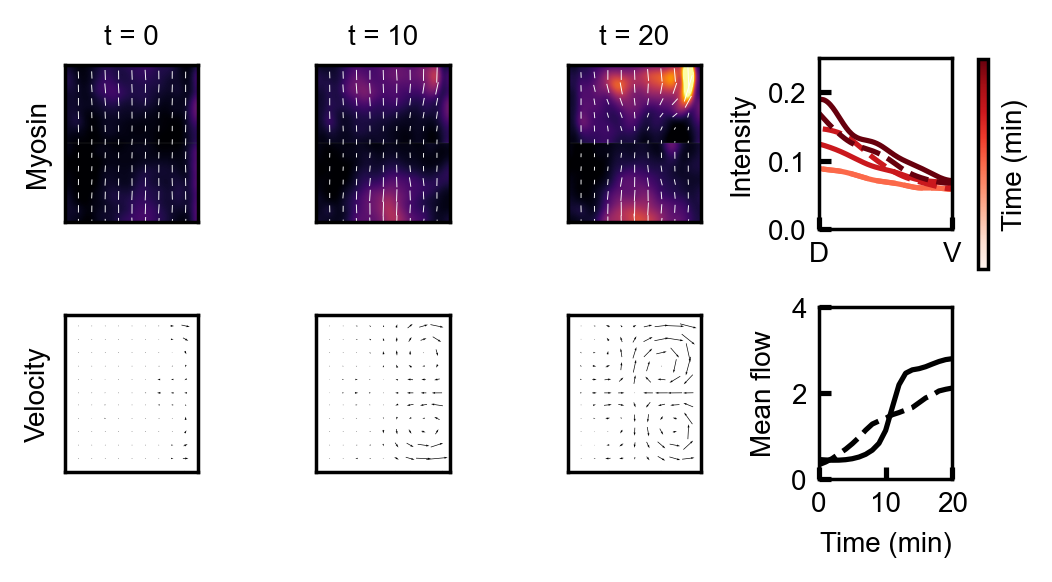

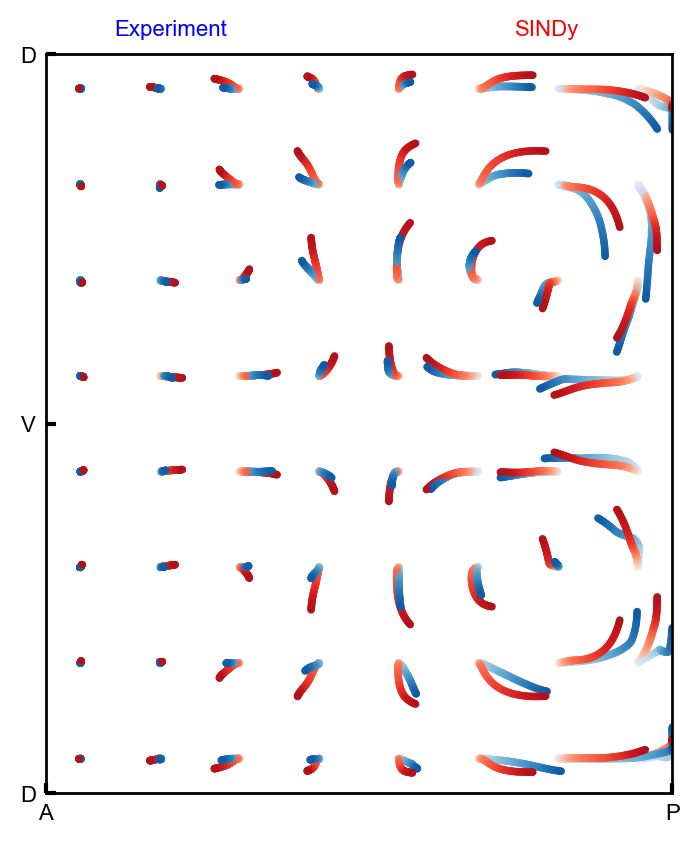

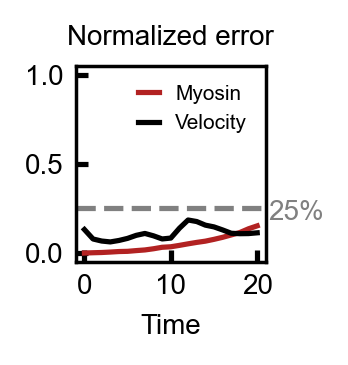

In [4]:
from mutant_datasets import TwistDataset
from morphogenesis.forecasting.closed_loop import ClosedFlyLoop

dataset = TwistDataset(tmin=0, tmax=20)
m0, v0, t0 = dataset.get_trajectory(202007171400)

print(m0.shape, t0.shape, v0.shape)
    
y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *m0.shape[-2:]])
])
print(y0.shape)
y0 = torch.FloatTensor(y0)


def rhs_eCad(self, m, s, v, E):
    '''
    Compute the right hand side of the myosin dynamics
    '''
    trm = self.einsum_('kkyx->yx', m)
    trE = self.einsum_('kkyx->yx', E)

    rhs  = -(0.110 - 0.095 * s) * m #Detachment
    rhs +=	(0.802 - 0.611 * s) * trm * m #Tension recruitment
    rhs +=	(0.708 + 0.133 * s) * m * trE #Strain recruitment
    rhs +=	(0.064 - 0.044 * s) * trm * self.gamma_dv_ #Hoop stress recruitment

    return rhs

model = ClosedFlyLoop(v_model, sigma=5, rhs=rhs_eCad, geo_dir='../flydrive/embryo_geometry')
model.fit(y0[None])
model.float()

m, s, v = model.integrate(y0.to(device), t0)

from plotting import sqh_vel_plot, trajectory_plot, residual_plot
sqh_vel_plot(t0, m, m0, v, v0, mmin=0.05, mmax=0.30)
trajectory_plot(v0, v)
residual_plot(t0, m, m0, v, v0)

100%|██████████| 3/3 [00:00<00:00, 406.02it/s]


(21, 2, 2, 236, 200) (21,) (21, 2, 236, 200)
torch.Size([5, 236, 200])
Using custom RHS
Using covariant gradient
Initializing
Using torchdiffeq solver


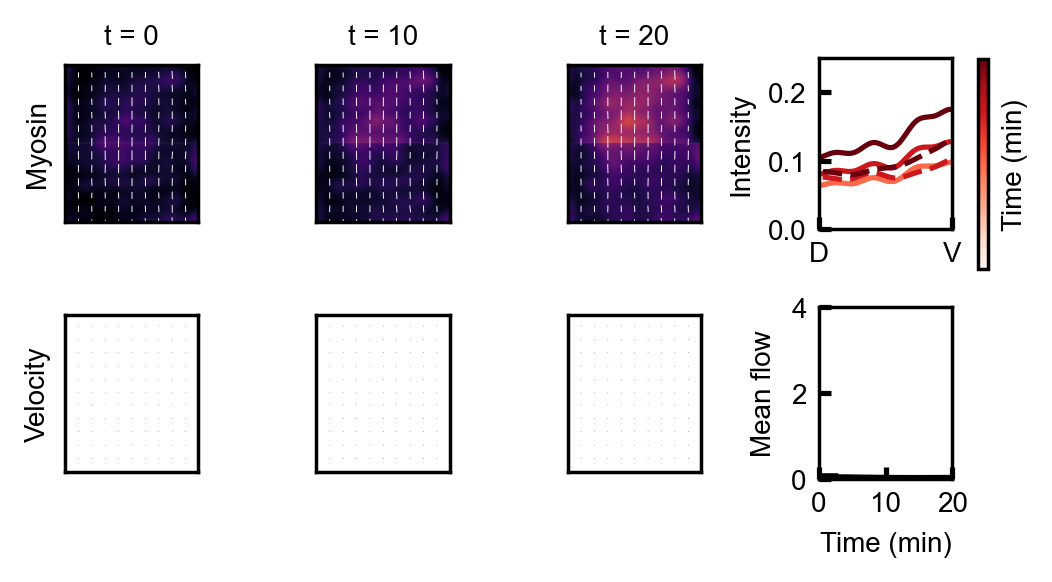

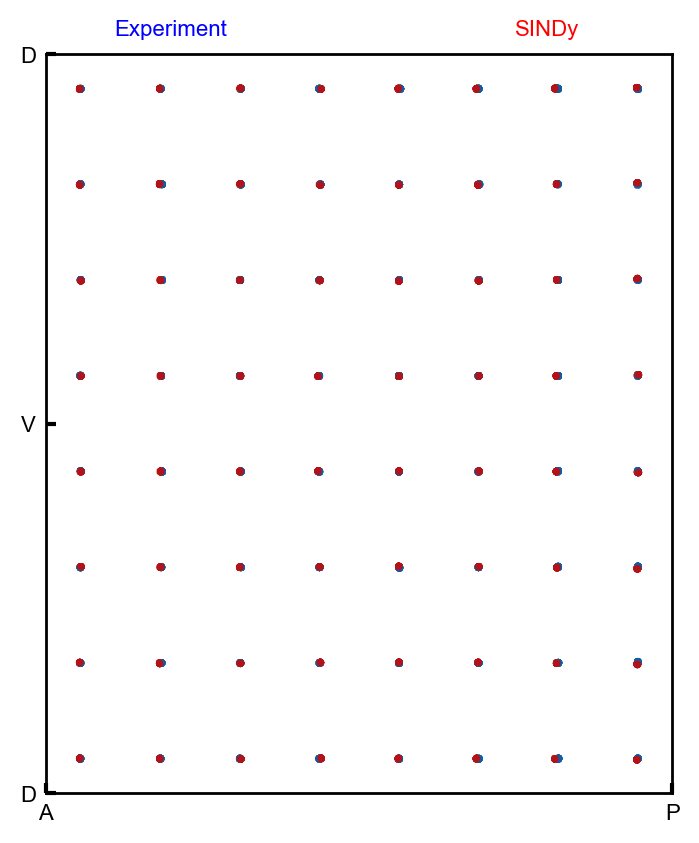

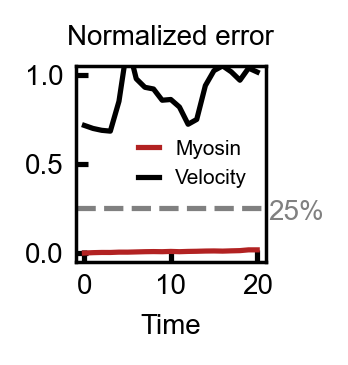

In [5]:
from mutant_datasets import TollDataset
dataset = TollDataset(tmin=0, tmax=20)
m0, v0, t0 = dataset.get_trajectory(202101191940)
print(m0.shape, t0.shape, v0.shape)
    
y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    0.1 * (s0[0].reshape([1, 236, 200]) - np.mean(s0[0])) + np.mean(s0[0]),
])
y0 = torch.FloatTensor(y0)
print(y0.shape)

model = ClosedFlyLoop(v_model, sigma=5, rhs=rhs_eCad, geo_dir='../flydrive/embryo_geometry')
model.fit(y0[None])
model.float()

m, s, v = model.integrate(y0.to(device), t0)

from plotting import sqh_vel_plot, trajectory_plot, residual_plot
sqh_vel_plot(t0, m, m0, v, v0, mmin=0.05, mmax=0.30)
trajectory_plot(v0, v)
residual_plot(t0, m, m0, v, v0)

100%|██████████| 4/4 [00:00<00:00, 611.55it/s]


(21, 2, 2, 236, 200) (21,) (21, 2, 236, 200)
torch.Size([5, 236, 200])
Using custom RHS
Using covariant gradient
Initializing
Using torchdiffeq solver
0.009185394295916385 0.07327801523831295


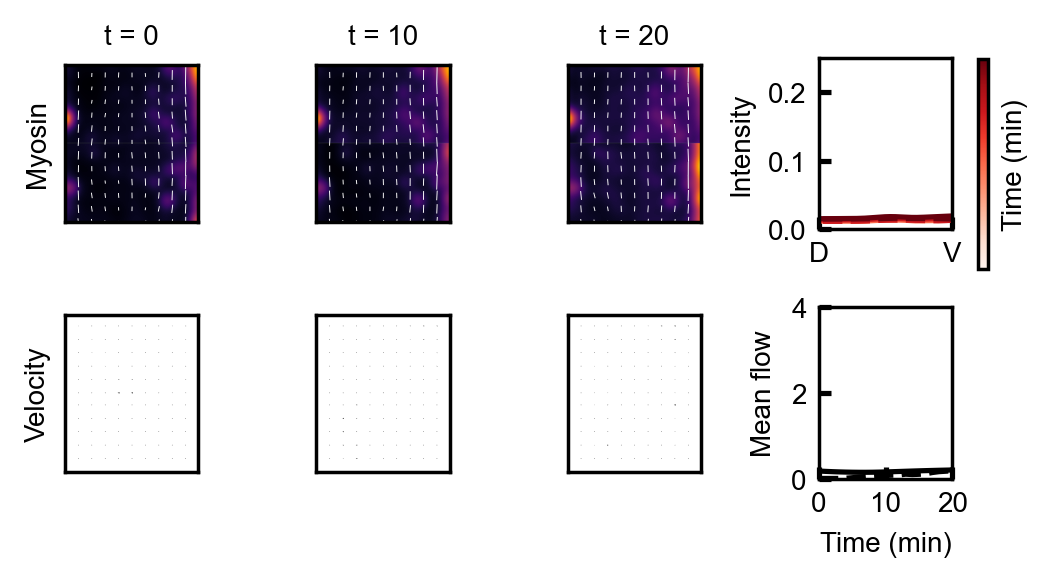

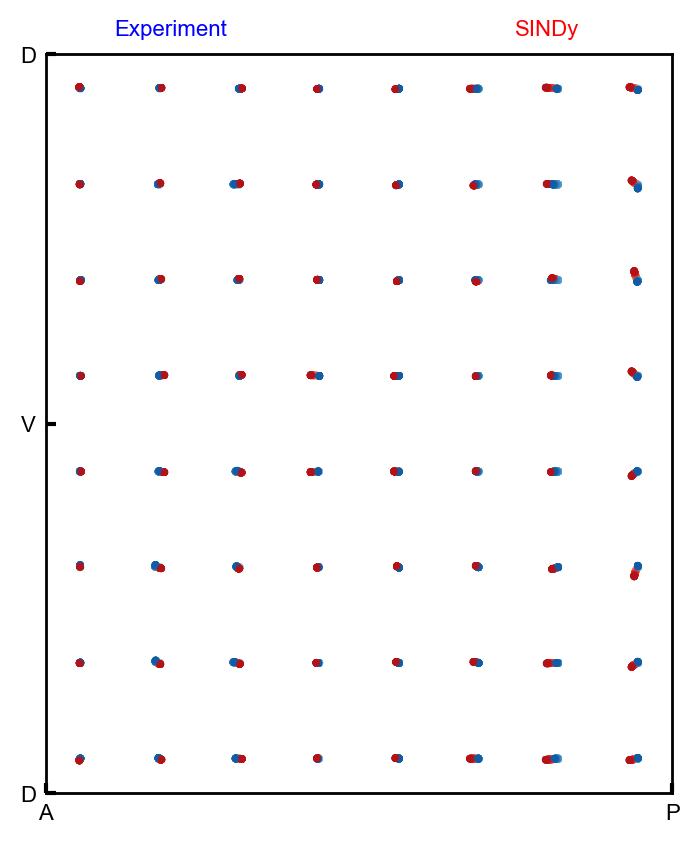

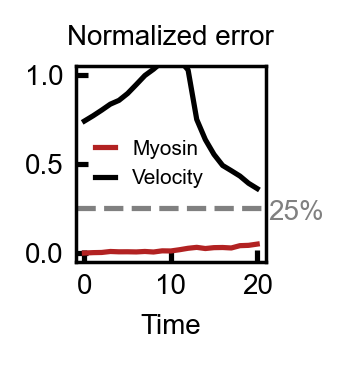

In [6]:
from mutant_datasets import SpaetzleDataset
dataset = SpaetzleDataset(tmin=0, tmax=20)
m0, v0, t0 = dataset.get_trajectory(201712201630)
print(m0.shape, t0.shape, v0.shape)
    
y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    0.1 * (s0[0].reshape([1, 236, 200]) - np.mean(s0[0])) + np.mean(s0[0]),
])
y0 = torch.FloatTensor(y0)
print(y0.shape)

model = ClosedFlyLoop(v_model, sigma=5, rhs=rhs_eCad, geo_dir='../flydrive/embryo_geometry')
model.fit(y0[None])
model.float()

m, s, v = model.integrate(y0.to(device), t0)

from plotting import sqh_vel_plot, trajectory_plot, residual_plot
sqh_vel_plot(t0, m, m0, v, v0)
trajectory_plot(v0, v)
residual_plot(t0, m, m0, v, v0)

# Point of comparison: WT models

(21, 2, 2, 236, 200) (21,) (21, 2, 236, 200)
torch.Size([5, 236, 200])
Using custom RHS
Using covariant gradient
Initializing
Using torchdiffeq solver


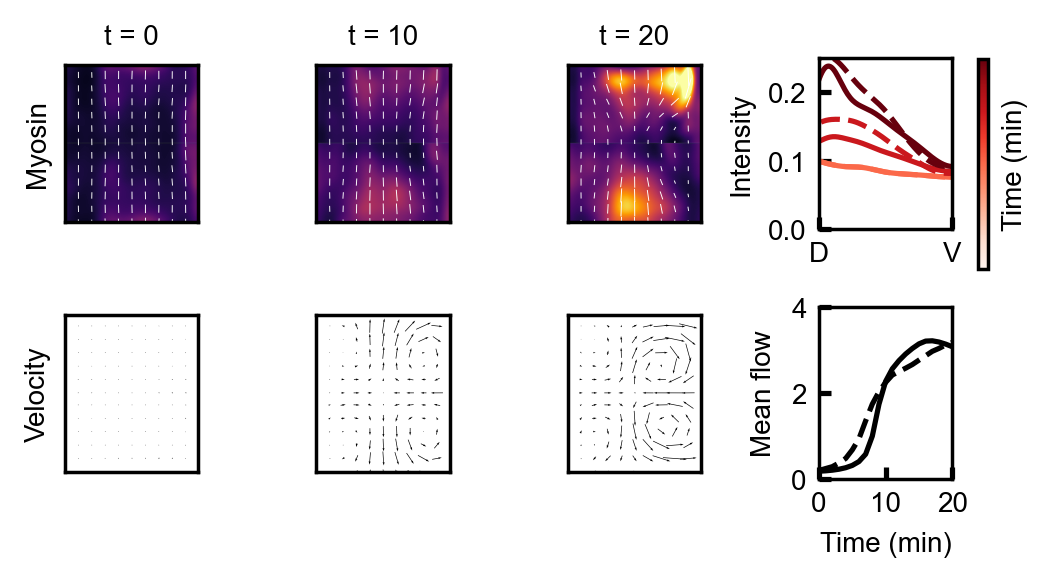

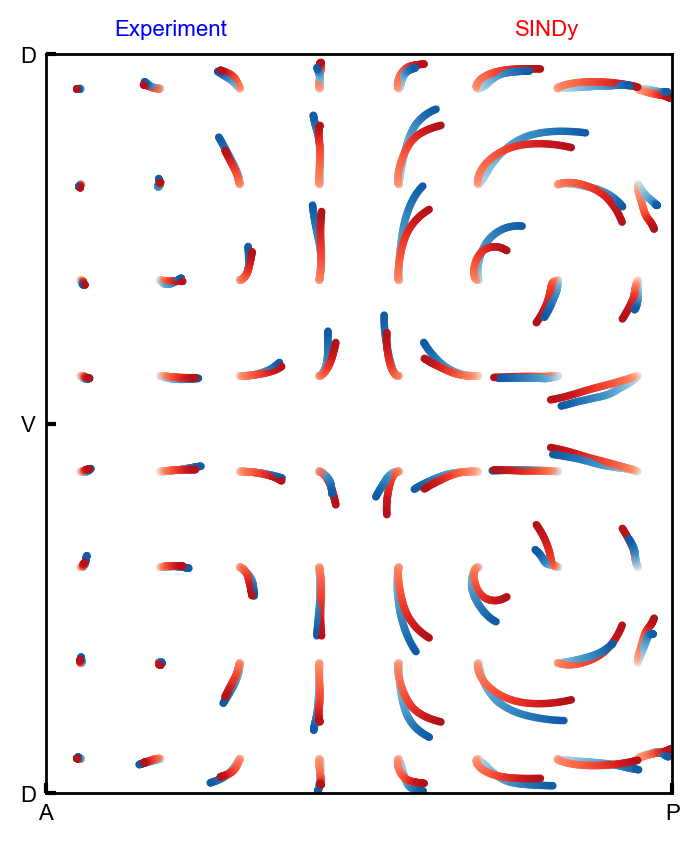

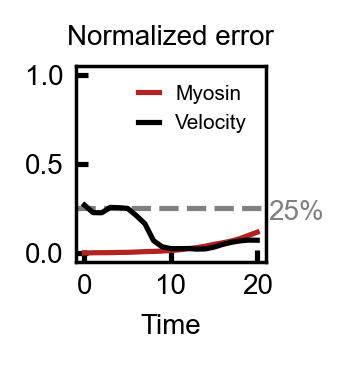

In [7]:
from morphogenesis.forecasting.closed_loop import ClosedFlyLoop
from morphogenesis.flow_networks.translation_models import VAE, MaskedVAE
from morphogenesis.flow_networks.forecasting_models import MaskedVAE_Evolver
from morphogenesis.forecasting.plot_utils import *
from morphogenesis.decomposition.decomposition_model import LeftRightSymmetrize
from pprint import pprint

#Collect initial conditions - m, c, v, and time
with h5py.File('../02.LearnDynamicsModel/myosin_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = 0, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]
print(m0.shape, t0.shape, v0.shape)
    
y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *m0.shape[-2:]])
])
y0 = torch.FloatTensor(y0)
print(y0.shape)

def rhs_eCad(self, m, s, v, E):
    '''
    Compute the right hand side of the myosin dynamics
    '''
    trm = self.einsum_('kkyx->yx', m)
    trE = self.einsum_('kkyx->yx', E)

    rhs  = -(0.110 - 0.095 * s) * m #Detachment
    rhs +=	(0.802 - 0.611 * s) * trm * m #Tension recruitment
    rhs +=	(0.708 + 0.133 * s) * m * trE #Strain recruitment
    rhs +=	(0.064 - 0.044 * s) * trm * self.gamma_dv_ #Hoop stress recruitment

    return rhs


model = ClosedFlyLoop(v_model, sigma=5, rhs=rhs_eCad, geo_dir='../flydrive/embryo_geometry')
model.fit(y0[None])
model.float()

m, s, v = model.integrate(y0.to(device), t0)

from plotting import sqh_vel_plot, trajectory_plot, residual_plot
sqh_vel_plot(t0, m, m0, v, v0, mmin=0.05, mmax=0.30)
trajectory_plot(v0, v)
residual_plot(t0, m, m0, v, v0)